# Damped-Local-Trend(DLT) Example

In [1]:
import pandas as pd
import numpy as np
from uTS.dlt import DLT
from uTS.utils.utils import plot_predicted_data

## Data

In [2]:
DATA_FILE = "./data/iclaims.example.csv"

In [3]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [4]:
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

### Data Transformation

In [5]:
df=raw_df.copy()
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] = \
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log, axis=1)
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


### Train / Test Split

In [6]:
test_size=52
train_df=df[:-test_size]

# in uTS we make assertion that test dates need to be between train start/end
test_df=df[-test_size:]

## MAP Fit and Predict

In [7]:
dlt_map=DLT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='map'
)

In [8]:
dlt_map.fit(df=train_df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9586c2ed51481aea4786dd4031ffe7d5 NOW.


In [20]:
dlt_map.aggregated_posteriors

{'mean': None,
 'median': None,
 'map': {<LocalTrendStanSamplingParameters.LOCAL_TREND_LEVELS: 'l'>: array([12.67689632, 12.78705103, 12.58658888, 12.58000853, 12.8097007 ,
         12.78122841, 12.79327602, 12.85890842, 12.96881361, 12.94762705,
         13.0112424 , 13.93136486, 13.92470498, 13.94538944, 14.08688807,
         13.98724932, 13.96962354, 13.89759292, 13.93433931, 13.93500183,
         13.89330679, 13.87880765, 13.86563138, 13.91250507, 13.90764952,
         14.00518182, 13.98168097, 12.25820129, 12.12648536, 12.18597086,
         12.29643785, 12.37928233, 12.34976164, 12.36630535, 12.40406728,
         13.85280001, 12.67639853, 12.68269336, 12.63365392, 12.62582432,
         12.67290347, 12.43655409, 12.49983295, 12.498728  , 12.52165076,
         12.34542904, 12.53995034, 12.36549149, 12.79699297, 12.40205007,
         12.52439363, 12.53257699, 12.55919313, 12.72151261, 12.40495371,
         12.53632006, 12.66224937, 12.63037788, 12.6658465 , 12.67444996,
         12.6

In [10]:
predicted_df = dlt_map.predict(df=test_df)

In [11]:
predicted_df.head(5)

,week,prediction
0,2017-07-02,14.202930
1,2017-07-09,14.307286
2,2017-07-16,14.054162
3,2017-07-23,13.915405
4,2017-07-30,13.888957


/Users/edwinng/work/venv/env3_uTS/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


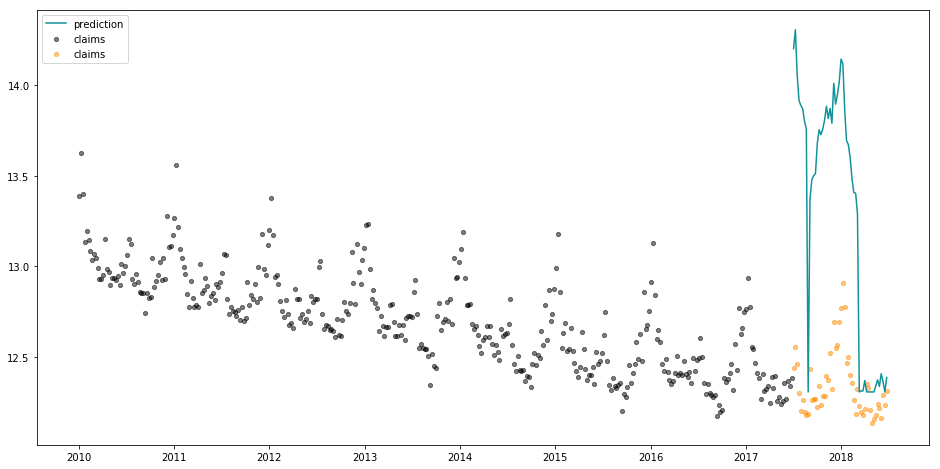

In [14]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_map.date_col, actual_col=dlt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## MCMC Fit and Predict

In [15]:
dlt_mcmc = DLT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    num_warmup=4000, 
    num_sample=500,
    sample_method='mcmc',
    predict_method='full',
    n_bootstrap_draws=500
)

In [16]:
dlt_mcmc.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [17]:
predicted_df = dlt_mcmc.predict(df=test_df)

In [18]:
predicted_df.tail(5)

,week,5,50,95
47,2018-05-27,12.204189,12.389923,1.552712e+28
48,2018-06-03,12.145862,12.321828,2.222859e+28
49,2018-06-10,12.218405,12.419627,1.373127e+28
50,2018-06-17,12.196064,12.398475,2.450569e+28
51,2018-06-24,12.240452,12.441292,1.084396e+28


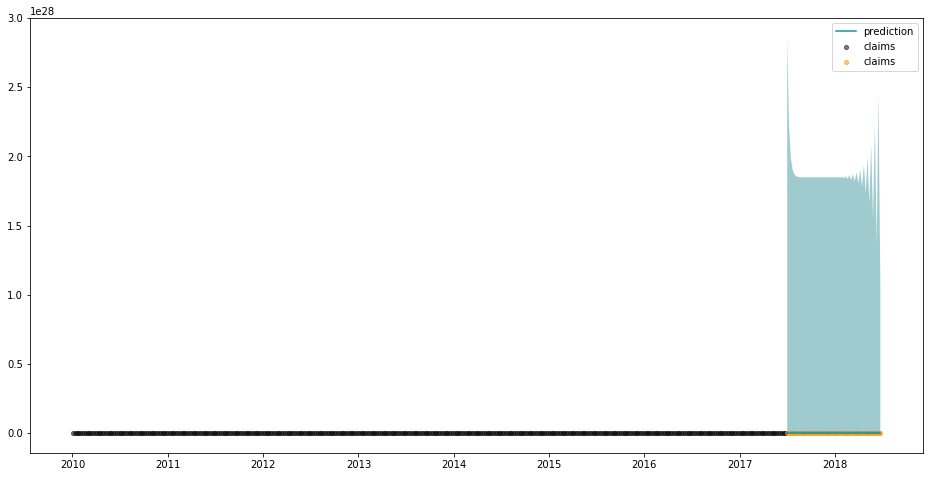

In [19]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_mcmc.date_col, actual_col=dlt_mcmc.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Mean Fit and Predict Decomp

In [17]:
dlt_mean=LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='mean'
)

In [18]:
dlt_mean.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [19]:
predicted_df = dlt_mean.predict(df=test_df, decompose=True)

In [20]:
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2017-07-02,12.407413,12.473719,-0.066306,0.0
1,2017-07-09,12.523948,12.470927,0.053021,0.0
2,2017-07-16,12.373218,12.468535,-0.095317,0.0
3,2017-07-23,12.226427,12.466299,-0.239873,0.0
4,2017-07-30,12.175862,12.464125,-0.288264,0.0


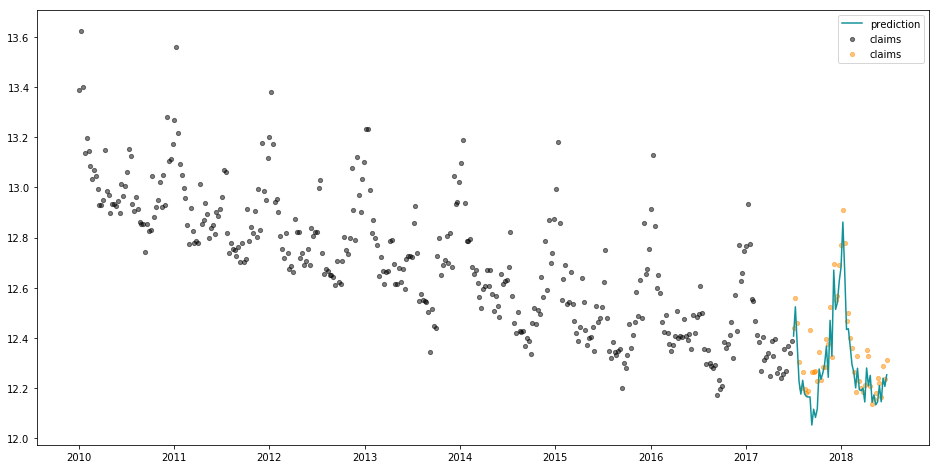

In [21]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_mean.date_col, actual_col=dlt_mean.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## MAP Fit and Decomp with Regression

In [22]:
dlt_reg=LGT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='map'
)

In [23]:
dlt_reg.fit(df=train_df)

In [24]:
predicted_df = dlt_reg.predict(df=test_df, decompose=True)

In [25]:
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2017-07-02,12.412338,12.451823,-0.054176,0.014691
1,2017-07-09,12.526810,12.448625,0.067583,0.010603
2,2017-07-16,12.369013,12.446739,-0.088252,0.010526
3,2017-07-23,12.220285,12.444948,-0.231638,0.006975
4,2017-07-30,12.180411,12.443165,-0.271892,0.009138
